In [28]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import random_split

In [1]:
train_path = 'augmented_data/train'
test_path = 'augmented_data/test'

In [33]:
basic_transform = transforms.ToTensor()

train_dataset = datasets.ImageFolder(root=train_path, transform=basic_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=basic_transform)

# Split 80% train, 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [36]:
print("Class labels:", train_dataset.dataset.classes)

Class labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [30]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [21]:
# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))  # Assume 7 classes
model = model.to(device)

cuda


C:\Users\kylin\anaconda3\envs\torch-gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kylin\anaconda3\envs\torch-gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# loss average: print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / total:.4f}, Train Accuracy: {100 * correct / total:.2f}%")

In [41]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Early stopping params
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


Epoch 1/10 | Train Loss: 0.0468, Train Acc: 98.43% | Val Loss: 0.1386, Val Acc: 95.82%
Epoch 2/10 | Train Loss: 0.0365, Train Acc: 98.81% | Val Loss: 0.1611, Val Acc: 95.59%
Epoch 3/10 | Train Loss: 0.0417, Train Acc: 98.64% | Val Loss: 0.1637, Val Acc: 95.10%
Epoch 4/10 | Train Loss: 0.0338, Train Acc: 98.90% | Val Loss: 0.1735, Val Acc: 94.95%
Epoch 5/10 | Train Loss: 0.0392, Train Acc: 98.71% | Val Loss: 0.1934, Val Acc: 94.77%
Epoch 6/10 | Train Loss: 0.0337, Train Acc: 98.90% | Val Loss: 0.1845, Val Acc: 94.79%
Early stopping triggered at epoch 6


In [37]:
# model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Test Accuracy: {100 * correct / total:.2f}%')

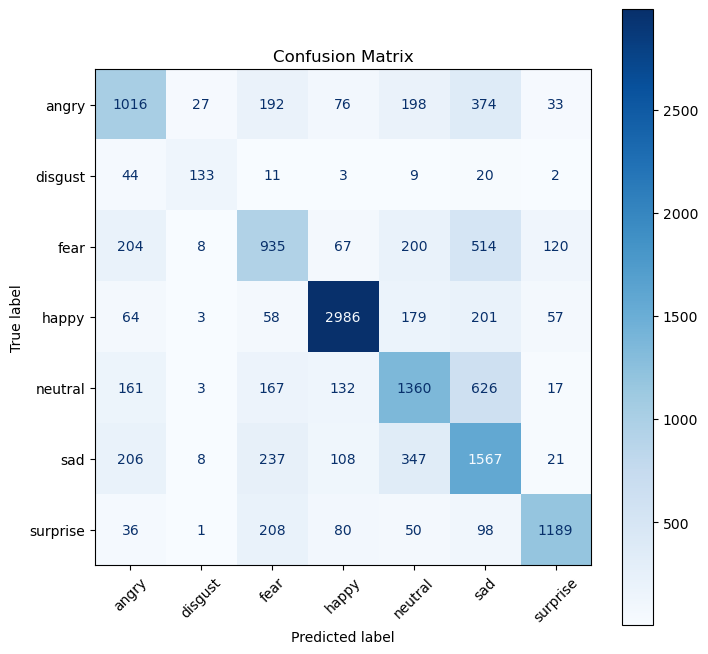

In [42]:
# Confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.dataset.classes 

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

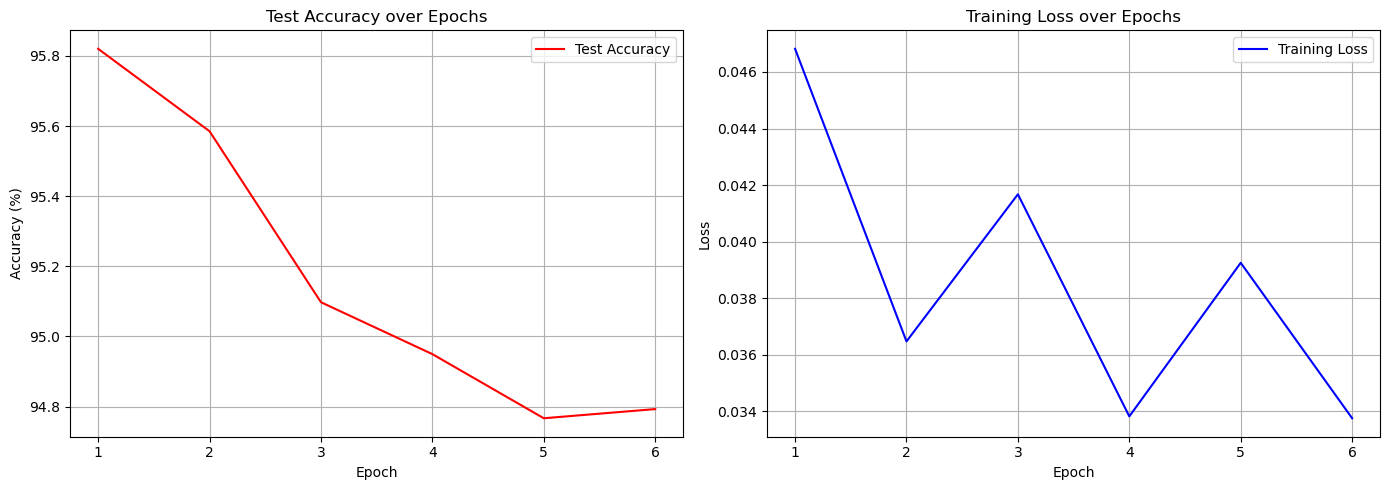

In [43]:
epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracies, 'r', label='Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [44]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

       angry       0.59      0.53      0.56      1916
     disgust       0.73      0.60      0.66       222
        fear       0.52      0.46      0.48      2048
       happy       0.87      0.84      0.85      3548
     neutral       0.58      0.55      0.57      2466
         sad       0.46      0.63      0.53      2494
    surprise       0.83      0.72      0.77      1662

    accuracy                           0.64     14356
   macro avg       0.65      0.62      0.63     14356
weighted avg       0.65      0.64      0.64     14356

